In [1]:
import cv2
import time

import numpy as np
import math
import copy

%matplotlib inline 
import matplotlib.pyplot as plt
%matplotlib inline

from bokeh.plotting import figure
from bokeh.io import output_notebook, show, push_notebook
from tqdm import tqdm

import IPython.display as Disp
from ipywidgets import widgets

In [2]:
#global initialization 
x_end = y_end=0
# All coordonates are initialized to 0
class RobotState:
    def __init__(self, x=0, y=0, r=0, angle=0):
        self.x = x
        self.y = y
        self.angle = angle 

robot_state = RobotState()

# size of our environment grid
num_cases_x = 8  # horizontal cells (valeur arbitraire ici juste pour que ca marche dans mon exemple) 
num_cases_y = 6   # vertical cells

# Initializing our matrix containing the environment information
center_matrix = [[None for _ in range(num_cases_x)] for _ in range(num_cases_y)] #jsp si c'est comme ca qu'on initialise a zero une matrice
state_matrix = [[None for _ in range(num_cases_x)] for _ in range(num_cases_y)]
debug_matrix = [[None for _ in range(num_cases_x)] for _ in range(num_cases_y)]

#camera related initialization 
cam = cv2.VideoCapture(0)

#Lower the resolution
cam.set(3, 1280)
cam.set(4, 720)

# Initialize a variable to store the last time an image was acquired
last_image_time = time.time()
result, image = cam.read()

2023-12-06 14:30:48.489 Python[2720:149722] WARNING: AVCaptureDeviceTypeExternal is deprecated for Continuity Cameras. Please use AVCaptureDeviceTypeContinuityCamera and add NSCameraUseContinuityCameraDeviceType to your Info.plist.


In [3]:
def pre_processing(image):
    """    
    Preprocess an image for use in computer vision applications.
    
    Arguments:
    image : The input image to be preprocessed.
        
    Returns:
    filtered_image : The preprocessed image.
    """
    # Convert the image to grayscale for filtering.
    image_grey = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply bilateral filtering to reduce noise while preserving edges.
    bilateral = cv2.bilateralFilter(image_grey, d=5, sigmaColor=25, sigmaSpace=25)
    
    # Apply Contrast Limited Adaptive Histogram Equalization (CLAHE) for enhancing details.
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    filtered_image1 = clahe.apply(bilateral)
    
    # Apply Gaussian blur to further use 
    filtered_image = cv2.GaussianBlur(filtered_image1, (5, 5), 0)
    
    return filtered_image 

In [4]:
def robot_info(keypoints, result_image, robot_state):
    """
    Update the essential information to describe the state of the robot.
    
    Arguments:
        keypoints: Detected keypoints representing potential robot positions.
        result_image: The image on which to draw the keypoints.
        robot_state: An instance of RobotState containing the coordinates and angle of the robot.
        
    Returns:
        robot_state: The updated RobotState instance.
    """
   
    # Filter by Circularity
    params.filterByCircularity = True
    params.minCircularity = 0.8
    params.maxCircularity = 1
        
    # Filter by color
    params.filterByColor = True

    x=y=r=x_big=y_big=r_big=x_small=y_small=r_small=0

    # Minimum circle radius we want to detect
    small_circle_radius_threshold_max = 13 #(le gros il fais 25 et le petit 18 pour la resolution normale)
    small_circle_radius_threshold_min = 8
    # Check if any blobs (potential circles) were detected
    if keypoints:
#---- 
#     print(f"{len(keypoints)} blobs detected.")
#----                 
        # Draw circles on the original image
        for keypoint in keypoints:
            x = int(keypoint.pt[0])
            y = int(keypoint.pt[1])
            r = int(keypoint.size / 2)

            if small_circle_radius_threshold_min < r < small_circle_radius_threshold_max:
                x_small = x
                y_small = y
                r_small = r
            elif r > small_circle_radius_threshold_max:
                x_big = x
                y_big = y
                r_big = r
#----        
        # print(robot_state.x,robot_state.y,robot_state.r)
        print('r_small =', r_small)
        print('r_big =', r_big)
        cv2.circle(result_image, (x_big, y_big), r_big, (255, 0, 255), 8) # just to check on the video
        cv2.circle(result_image, (x_small, y_small), r_small, (255, 0, 255), 8) # just to check on the video

           # print(r)
#----
        robot_state.x = x_big
        robot_state.y = y_big
        #Robot orientation = angle between the trajectorie of the robot and the vertical axis
        Vect_dir = (x_small - x_big , y_small - y_big)
        Vertical = (0, 1)
            
        dot_product = Vect_dir[0] * Vertical[0] + Vect_dir[1] * Vertical[1]
            
        magnitude_dir = math.sqrt(Vect_dir[0]**2 + Vect_dir[1]**2)
        magnitude_V = math.sqrt(Vertical[0]**2 + Vertical[1]**2)
                
        # Angle in radiants
        if magnitude_dir != 0 and magnitude_V != 0:
            angle_rad = math.acos(dot_product / (magnitude_dir * magnitude_V))
        else:
            angle_rad = 0
        # Convertion in degrees
        robot_state.angle = math.degrees(angle_rad)
# ---
#print(robot_state.angle)
#---
    return robot_state 

In [5]:
def order_points(pts):
    rect = np.zeros((4, 2), dtype="float32")
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect

def grid_setting(filtered_image, center_matrix, state_matrix):
    BLACK = 1
    WHITE = 0
    black_threshold = 30
    white_threshold = 110
    red_threshold_inf = 65
    red_threshold_sup = 105
    robot_pos_delta_x = 80
    robot_pos_delta_y = 80
    min_area_threshold = 75000

    top_right = top_left = bottom_right = bottom_left =  [0,0]
    x_center = y_center = x_end = y_end = 0

    contours_image = cv2.Canny(filtered_image, 50, 150, apertureSize=3)
    contours, _ = cv2.findContours(contours_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    center_matrix_prev = copy.deepcopy(center_matrix)
    state_matrix_prev = copy.deepcopy(state_matrix)
    
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        if cv2.contourArea(largest_contour) > min_area_threshold:
            peri = cv2.arcLength(largest_contour, True)
            approx = cv2.approxPolyDP(largest_contour, 0.02 * peri, True)
            
            if len(approx) == 4:
                cv2.drawContours(result_image, [approx], -1, (0, 255, 0), 2)
                ordered_points = order_points(approx.reshape(4, 2))

                destination_points = np.array([
                    [0, 0],
                    [filtered_image.shape[1] - 1, 0],
                    [filtered_image.shape[1] - 1, filtered_image.shape[0] - 1],
                    [0, filtered_image.shape[0] - 1]
                ], dtype="float32")
                
                matrix = cv2.getPerspectiveTransform(ordered_points, destination_points)
                warped_image = cv2.warpPerspective(filtered_image, matrix, (filtered_image.shape[1], filtered_image.shape[0]))
                # Right after you calculate the perspective transformation matrix
                inverse_matrix = cv2.invert(matrix)[1]
                        
       # Compute the cell size using the warped image dimensions
                case_width = warped_image.shape[1] // num_cases_x
                case_height = warped_image.shape[0] // num_cases_y

                print (case_width)
                print (case_height)
                
                          # When mapping the centers back to the original image space
                for i in range(num_cases_y):
                    for j in range(num_cases_x):
                        center_x = j * case_width + case_width // 2
                        center_y = i * case_height + case_height // 2
                        
                        # Convert to a floating-point type
                        float_center = np.array([[[center_x, center_y]]], dtype=np.float32)
                        
                        # Map the centers back to the original image space using the inverse matrix
                        original_center = cv2.perspectiveTransform(float_center, inverse_matrix)
                        original_center = tuple(original_center[0][0].astype(int))
                        
                        # Draw the cell center on the original image
                        cv2.circle(result_image, original_center, 5, (0, 0, 255), -1)
                        
                        # Update center_matrix with the mapped center
                        center_matrix[i][j] = original_center
                        
                        x_center, y_center = original_center  # Unpack the tuple
                        center_value = filtered_image[y_center, x_center]  # Access the image at the y, x coordinates
                        debug_matrix[i][j] = center_value  # Store the grayscale value
                        
                        #if abs(x_center-robot_state.x) <= robot_pos_delta_x and abs(y_center-robot_state.y) <= robot_pos_delta_y:
           #                 print('robot_x',robot_state.x)
            #                print('center_case.x',center_matrix[i][j][0])
              #              print('robot_y',robot_state.y)
               #             print('center_case.y',center_matrix[i][j][1])


                   
                        if center_value < black_threshold :
                            state_matrix[i][j] = WHITE
                        else:
                            state_matrix[i][j] = BLACK     
                        if center_value > white_threshold:
                            state_matrix[i][j] = WHITE
                        if red_threshold_inf <= center_value <= red_threshold_sup:
                            x_end, y_end = center_matrix[i][j]
                            state_matrix[i][j] = WHITE

    else:
        center_matrix = copy.deepcopy(center_matrix_prev)
        state_matrix = copy.deepcopy(state_matrix_prev) # comme ca, si on cache on ne detect pas de controu et on garde notre matrice 
        
    return state_matrix, center_matrix, x_end, y_end


r_small = 11
r_big = 16
160
120


2023-12-06 14:30:50.349 Python[2720:149722] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.


r_small = 11
r_big = 16
160
120
r_small = 11
r_big = 16
160
120
r_small = 11
r_big = 16
160
120
r_small = 11
r_big = 16
160
120
r_small = 11
r_big = 16
160
120
r_small = 11
r_big = 16
160
120
r_small = 11
r_big = 16
160
120
r_small = 11
r_big = 16
160
120
r_small = 11
r_big = 16
r_small = 11
r_big = 16
r_small = 11
r_big = 16
160
120
r_small = 11
r_big = 16
160
120
r_small = 11
r_big = 16
160
120
r_small = 11
r_big = 16
160
120
r_small = 11
r_big = 16
160
120
r_small = 11
r_big = 16
160
120
r_small = 11
r_big = 16
160
120
r_small = 11
r_big = 16
160
120
r_small = 11
r_big = 16
r_small = 11
r_big = 16
r_small = 11
r_big = 16
r_small = 11
r_big = 16
r_small = 11
r_big = 16
r_small = 11
r_big = 16
160
120
r_small = 11
r_big = 16
160
120
r_small = 11
r_big = 16
160
120
r_small = 11
r_big = 16
160
120
r_small = 11
r_big = 16
160
120
r_small = 11
r_big = 16
160
120
r_small = 11
r_big = 16
160
120
r_small = 11
r_big = 16
160
120
r_small = 11
r_big = 16
160
120
r_small = 11
r_big = 16
160
120


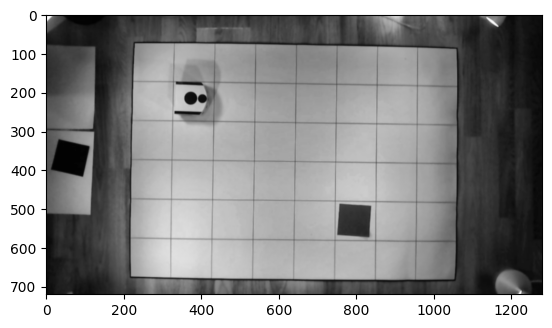

In [6]:
while True:
    
    start_time = time.time()  # Record the start time

    ret, frame = cam.read()
    if ret:
        result_image = frame.copy()  # Initialiser result_image avec une copie de l'image actuelle

        filtered_image = pre_processing(result_image)
        plt.imshow(cv2.cvtColor(filtered_image, cv2.COLOR_BGR2RGB))

        # Blob detector parameters for circle detection
        params = cv2.SimpleBlobDetector_Params()
        
        # Create a blob detector with the configured parameters
        detector = cv2.SimpleBlobDetector_create(params)
        
        # Detect blobs in the image
        keypoints = detector.detect(filtered_image)

        # Update the info about the robot
        robot_state = robot_info(keypoints, result_image, robot_state)

        state_matrix, center_matrix, x_end, y_end = grid_setting(filtered_image,center_matrix,state_matrix)

        #print(x_end,y_end)
#        print('state_matrix : ')
 #       print(state_matrix[0])
  #      print(state_matrix[1])
   #     print(state_matrix[2])
    #    print(state_matrix[3])
     #   print(state_matrix[4])
      #  print(state_matrix[5])

#        print('debug_matrix : ')
 #       print(debug_matrix[0])
  #      print(debug_matrix[1])
   #     print(debug_matrix[2])
    #    print(debug_matrix[3])
     #   print(debug_matrix[4])
      #  print(debug_matrix[5])
        
        cv2.imshow('Live Footage', result_image)

        #if you click on any key it stops the program
        if cv2.waitKey(1) == 27:
            break
#-----        
  #      print(state_matrix)
#-----
            # Wait until a second has passed since the start of the iteration
        while time.time() - start_time < 1:
            time.sleep(0.01) 
    else:
        break

# Release the camera and close the window
cam.release()
cv2.destroyAllWindows()
for i in range(1, 5):
    cv2.waitKey(1)